# Libraries

In [21]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns 

import time 
from datetime import datetime

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
ls

Data_analysis_tasks_with_python.pdf            electricity_consumption.ipynb
LP_AT0080000870000000000000000097058_2019.csv  profil_LWS_2020_L.csv


# Load data 

In [14]:
lp = pd.read_csv('LP_AT0080000870000000000000000097058_2019.csv', 
                 sep=';', decimal=',', dayfirst=True, header=None, parse_dates=[0],
                 skiprows=7, names=['date','consumption'])

In [15]:
lp.head()

,date,consumption
0,01.01.2019 00:15,1.30
1,01.01.2019 00:30,0.77
2,01.01.2019 00:45,0.80
3,01.01.2019 01:00,0.78
4,01.01.2019 01:15,0.78


In [11]:
lp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         35040 non-null  object 
 1   consumption  35040 non-null  float64
dtypes: float64(1), object(1)
memory usage: 547.6+ KB


In [17]:
lp['date'] = pd.to_datetime(lp['date'], dayfirst=True, errors='coerce')

In [18]:
lp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         35032 non-null  datetime64[ns]
 1   consumption  35040 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 547.6 KB


## There is a couple of date (8) that is not being recognized 

In [20]:
lp.head()

,date,consumption
0,2019-01-01 00:15:00,1.30
1,2019-01-01 00:30:00,0.77
2,2019-01-01 00:45:00,0.80
3,2019-01-01 01:00:00,0.78
4,2019-01-01 01:15:00,0.78


<AxesSubplot:xlabel='date'>

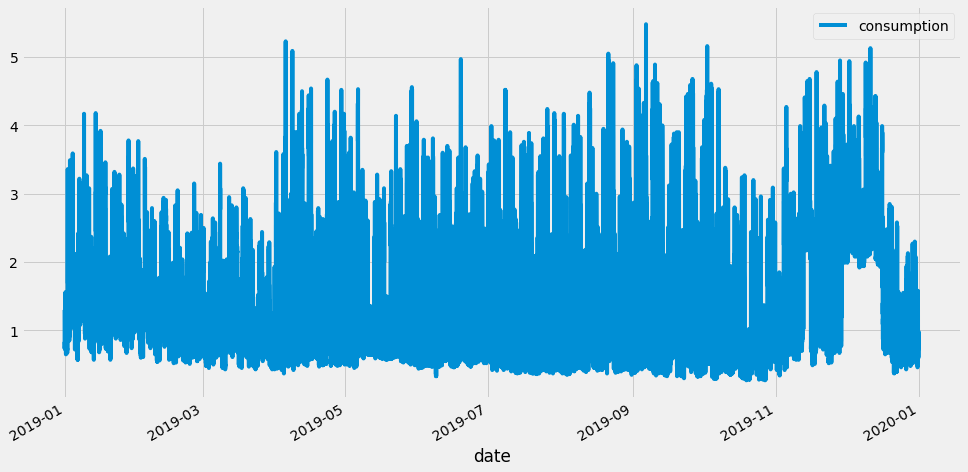

In [24]:
lp.plot(x='date', y='consumption', kind='line', figsize=(15,8))